In [1]:
# import sys
# !{sys.executable} -m pip install pyjanitor
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import glacierml_old as gl
import numpy as np
import warnings
from tensorflow.python.util import deprecation
import os
import logging
import seaborn as sns
import janitor
from tqdm import tqdm
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
deprecation._PRINT_DEPRECATION_WARNINGS = False
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# set definitions
T,TT,TTT = gl.data_loader()
# ,TT,TTT,TTTx,TTT_full
T_t = T.head()
gl.thickness_renamer(T)
gl.thickness_renamer(TT)

LR = np.logspace(-3,2,6)
VS = 0.2
Epochs = 500

glathida_list = TTT,TT,T
# ,TTT,TTTx

T.name = 'glacier'
T_t.name = 'T_t'
TT.name = 'band'
TTT.name = 'point'
# TTTx.name = 'TTTx'
# TTT_full.name = 'TTT_full'
pth_model = '/home/sa42/notebooks/glac/saved_models/'
pth_res = '/home/sa42/notebooks/glac/saved_results/'

Importing data...
Importing T database
Importing TT database
Importing TTT database
Import complete


In [3]:
vs = 0.2
ep = 100

# load models
print('Loading models....')

linear_model = {}
dnn_model = {}
for dataset in glathida_list:
    (train_features, test_features, train_labels, test_labels) = gl.data_splitter(dataset)
    for variable_name in tqdm(list(train_features) + ['MULTI']):
        for lr in LR:
            file_name = (
            pth_model 
            + dataset.name 
            + '_linear_' 
            + variable_name 
            + '_' 
            + str(lr)
            + '_'
            + str(vs)
            + '_'
            + str(ep)
            )
            
            linear_model[
                dataset.name 
                + '_' 
                + variable_name 
                + '_' 
                + str(lr)
            ] = tf.keras.models.load_model(file_name)
for dataset in glathida_list:
    (train_features, test_features, train_labels, test_labels) = gl.data_splitter(dataset)
    for variable_name in tqdm(list(train_features) + ['MULTI']):
        for lr in LR:
            file_name = (
            pth_model 
            + dataset.name 
            + '_dnn_' 
            + variable_name 
            + '_' 
            + str(lr)
            + '_'
            + str(vs)
            + '_'
            + str(ep)
            )
            
            dnn_model[
                dataset.name 
                + '_' 
                + variable_name 
                + '_' 
                + str(lr)
                + '_'
                + str(vs)
                + '_'
                + str(ep)
            ] = tf.keras.models.load_model(file_name)
print('Models loaded')


# load histories
print('Loading histories....')
linear_history = {}
dnn_history = {}
for dataset in glathida_list:
    (train_features, test_features, train_labels, test_labels) = gl.data_splitter(dataset)
    for variable_name in tqdm(list(train_features) + ['MULTI']):
        for lr in LR:
            file_name = (
                pth_res 
                + dataset.name 
                +'_linear_history_'
                + variable_name 
                + '_' + str(lr)
                + '_'
                + str(vs)
                + '_'
                + str(ep)
            )
            
            linear_history[
                dataset.name 
                +'_'
                + variable_name 
                + '_' 
                + str(lr)
                + '_'
                + str(vs)
                + '_'
                + str(ep)
            ]= pd.read_csv(file_name)

for dataset in glathida_list:
    (train_features, test_features, train_labels, test_labels) = gl.data_splitter(dataset)
    for variable_name in tqdm(list(train_features) + ['MULTI']):
        for lr in LR:
            file_name = (
                pth_res 
                + dataset.name 
                +'_dnn_history_'
                + variable_name 
                + '_' 
                + str(lr)
                + '_'
                + str(vs)
                + '_'
                + str(ep)
            )
            
            dnn_history[
                dataset.name 
                +'_'
                + variable_name 
                + '_' 
                + str(lr)
                + '_'
                + str(vs)
                + '_'
                + str(ep)
            ] = pd.read_csv(file_name)
print('Histories loaded')

loss = {}
for dataset in glathida_list:
    (train_features, test_features, train_labels, test_labels) = gl.data_splitter(dataset)
    loss[dataset.name + '_min'] = pd.DataFrame()
    loss[dataset.name + '_fin'] = pd.DataFrame()

    for lr in LR:
        file = (
        dataset.name
        +'_'
        + 'MULTI'
        + '_' 
        + str(lr)
        + '_'
        + str(vs)
        + '_'
        + str(ep))
        m_loss = dnn_history[file].min()
        m_loss['learning rate'] = str(lr)
        m_loss['validation split'] = str(vs)
        m_loss['epochs'] = str(ep)
        loss[dataset.name + '_min'] = loss[dataset.name + '_min'].append(m_loss,ignore_index=True)

        f = dnn_history[file].last_valid_index()
        f_loss = dnn_history[file].iloc[[f]]
        f_loss['learning rate'] = str(lr)
        f_loss['validation split'] = str(vs)
        f_loss['epochs'] = str(ep)
        loss[dataset.name + '_fin'] = loss[dataset.name + '_fin'].append(f_loss,ignore_index=True)

    loss[dataset.name + '_fin'] = loss[dataset.name + '_fin'].drop('Unnamed: 0',axis=1)
    loss[dataset.name + '_fin'] = loss[dataset.name + '_fin'].rename(columns = {
        'loss':'loss_final',
        'val_loss':'val_loss_final'
    })
    loss[dataset.name + '_min'] = loss[dataset.name + '_min'].drop('Unnamed: 0',axis=1)
    loss[dataset.name + '_min'] = loss[dataset.name + '_min'].rename(columns = {
        'loss':'loss_minimum',
        'val_loss':'val_loss_minimum'
    })
    
print('Results compiled')

Loading models....


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Models loaded
Loading histories....


100%|██████████| 5/5 [00:00<00:00, 195.76it/s]


Histories loaded
Results compiled


/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/ipykernel_launcher.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/ipykernel_launcher.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [4]:
loss['point_min']

,loss_minimum,val_loss_minimum,learning rate,validation split,epochs
0,135.078430,135.134964,0.001,0.2,100
1,123.584427,122.835548,0.01,0.2,100
2,134.031784,132.287537,0.1,0.2,100
3,155.673798,153.278351,1.0,0.2,100
4,188.198959,188.084259,10.0,0.2,100
5,191.172470,188.084366,100.0,0.2,100


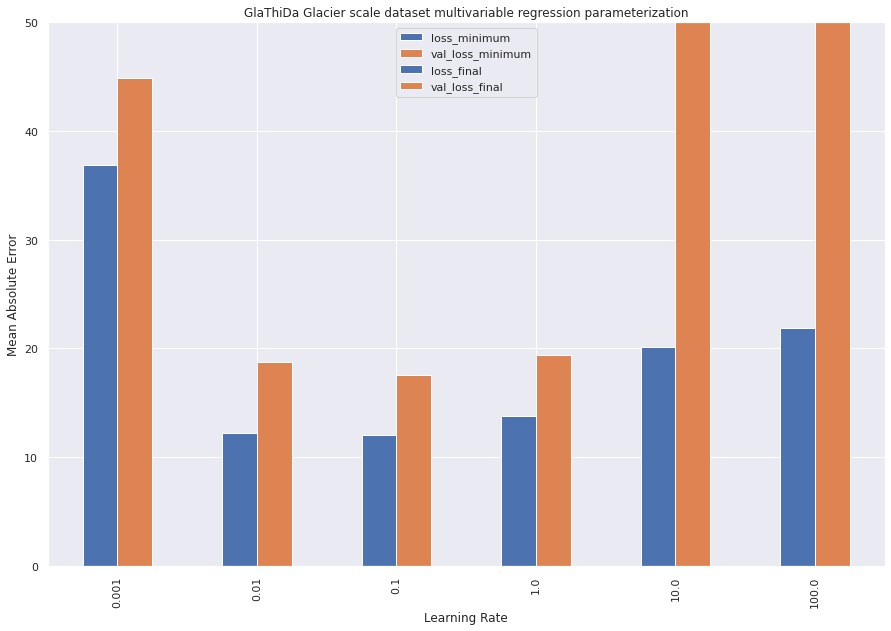

<Figure size 1080x720 with 0 Axes>

In [5]:
sns.set(rc={"figure.figsize":(15,10)})
ax = plt.gca()
ax.set_ylim([0,50])
loss['glacier_min'].plot(x='learning rate', y = ['loss_minimum', 'val_loss_minimum'], kind='bar',  ax=ax)
loss['glacier_fin'].plot(x='learning rate', y = ['loss_final', 'val_loss_final'], kind='bar',  ax=ax)

# loss['point_fin'].plot(x='learning rate', y = 'loss_final',color = 'blue',  ax=ax)
# loss['point_fin'].plot(x='learning rate', y = 'val_loss_final',color = 'green', ax=ax)
# loss['point_min'].plot(x='learning rate', y = 'loss_minimum', color = 'red', ax=ax)
# loss['point_min'].plot(x='learning rate', y = 'val_loss_minimum',color = 'orange', ax=ax)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('GlaThiDa Glacier scale dataset multivariable regression parameterization')
plt.show()
plt.tight_layout()

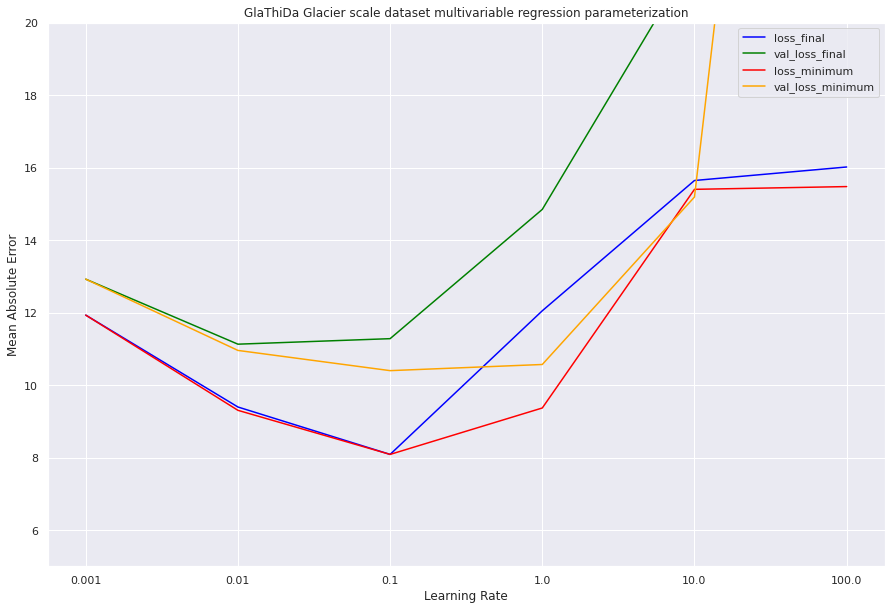

<Figure size 1080x720 with 0 Axes>

In [6]:
sns.set(rc={"figure.figsize":(15,10)})
ax = plt.gca()
ax.set_ylim([5,20])
loss['band_fin'].plot(x='learning rate', y = 'loss_final',color = 'blue',  ax=ax)
loss['band_fin'].plot(x='learning rate', y = 'val_loss_final',color = 'green', ax=ax)
loss['band_min'].plot(x='learning rate', y = 'loss_minimum', color = 'red', ax=ax)
loss['band_min'].plot(x='learning rate', y = 'val_loss_minimum',color = 'orange', ax=ax)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('GlaThiDa Glacier scale dataset multivariable regression parameterization')
plt.show()
plt.tight_layout()

In [49]:
glac_min = pd.DataFrame(loss['glacier_min'])
list(glac_min)
loss_min_idx = glac_min.index[glac_min['loss_minimum'] ==glac_min['loss_minimum'].min()]
val_loss_min_idx = glac_min.index[glac_min['val_loss_minimum'] ==glac_min['val_loss_minimum'].min()]

In [48]:
glac_min.loc[lm_idx]

,loss_minimum,val_loss_minimum,learning rate,validation split,epochs
2,10.108054,14.469899,0.1,0.2,100


In [50]:
glac_min.loc[val_loss_min_idx]

,loss_minimum,val_loss_minimum,learning rate,validation split,epochs
2,10.108054,14.469899,0.1,0.2,100


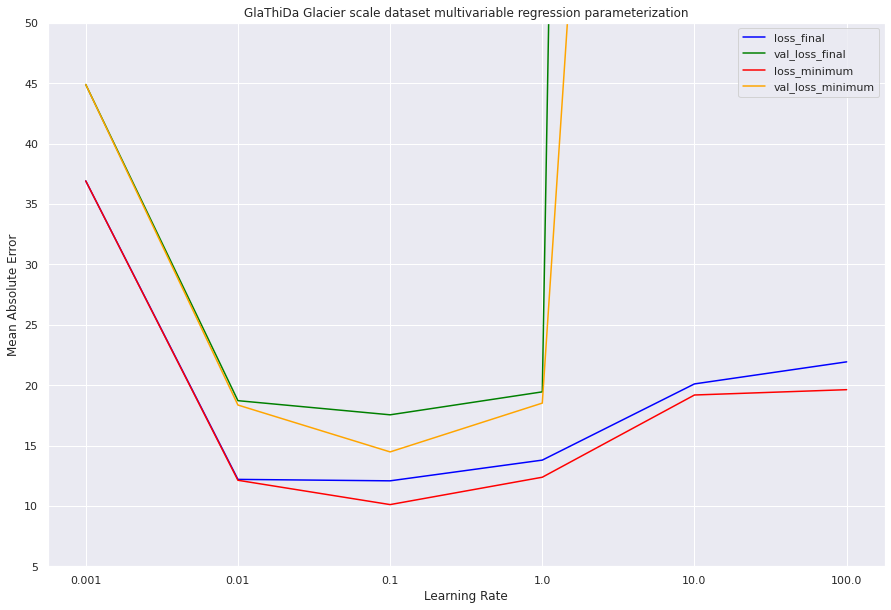

<Figure size 1080x720 with 0 Axes>

In [7]:
sns.set(rc={"figure.figsize":(15,10)})
ax = plt.gca()
ax.set_ylim([5,50])
loss['glacier_fin'].plot(x='learning rate', y = 'loss_final',color = 'blue',  ax=ax)
loss['glacier_fin'].plot(x='learning rate', y = 'val_loss_final',color = 'green', ax=ax)
loss['glacier_min'].plot(x='learning rate', y = 'loss_minimum', color = 'red', ax=ax)
loss['glacier_min'].plot(x='learning rate', y = 'val_loss_minimum',color = 'orange', ax=ax)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('GlaThiDa Glacier scale dataset multivariable regression parameterization')
plt.show()
plt.tight_layout()

In [8]:
loss

{'point_min':    loss_minimum  val_loss_minimum learning rate validation split epochs
 0    135.078430        135.134964         0.001              0.2    100
 1    123.584427        122.835548          0.01              0.2    100
 2    134.031784        132.287537           0.1              0.2    100
 3    155.673798        153.278351           1.0              0.2    100
 4    188.198959        188.084259          10.0              0.2    100
 5    191.172470        188.084366         100.0              0.2    100,
 'point_fin':    loss_final  val_loss_final learning rate validation split epochs
 0  135.078430      135.134964         0.001              0.2    100
 1  123.584427      123.439842          0.01              0.2    100
 2  134.036621      133.302292           0.1              0.2    100
 3  157.538635      154.715424           1.0              0.2    100
 4  188.219650      188.522598          10.0              0.2    100
 5  191.251984      188.170715         100.0    

In [9]:
# ccccombo_breaker()

In [10]:
dnn_model

{'point_POINT_LAT_0.001_0.2_100': <keras.engine.sequential.Sequential at 0x7f84457b8f90>,
 'point_POINT_LAT_0.01_0.2_100': <keras.engine.sequential.Sequential at 0x7f83e033d8d0>,
 'point_POINT_LAT_0.1_0.2_100': <keras.engine.sequential.Sequential at 0x7f83e01a1f10>,
 'point_POINT_LAT_1.0_0.2_100': <keras.engine.sequential.Sequential at 0x7f83e006a6d0>,
 'point_POINT_LAT_10.0_0.2_100': <keras.engine.sequential.Sequential at 0x7f839c6be510>,
 'point_POINT_LAT_100.0_0.2_100': <keras.engine.sequential.Sequential at 0x7f839c738bd0>,
 'point_POINT_LON_0.001_0.2_100': <keras.engine.sequential.Sequential at 0x7f8445364610>,
 'point_POINT_LON_0.01_0.2_100': <keras.engine.sequential.Sequential at 0x7f839c337110>,
 'point_POINT_LON_0.1_0.2_100': <keras.engine.sequential.Sequential at 0x7f839c1a0f10>,
 'point_POINT_LON_1.0_0.2_100': <keras.engine.sequential.Sequential at 0x7f839c06a2d0>,
 'point_POINT_LON_10.0_0.2_100': <keras.engine.sequential.Sequential at 0x7f8380690c50>,
 'point_POINT_LON_100.

(0.0, 300.0)

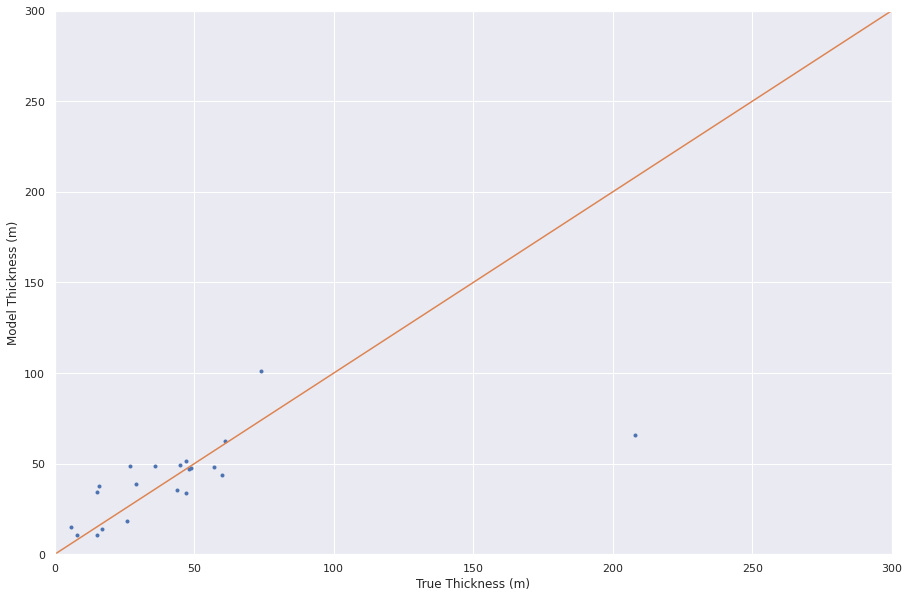

In [11]:
(train_features, test_features,
train_labels, test_labels) = gl.data_splitter(T)
y = dnn_model['glacier_MULTI_0.01_0.2_100'].predict(test_features)
fig,ax=plt.subplots(1,1,figsize=(15,10))
fig.patch.set_facecolor('w')
plt.plot(test_labels,y,'.')
plt.plot((0,300),(0,300),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((0,300))
plt.ylim((0,300))
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP_T")

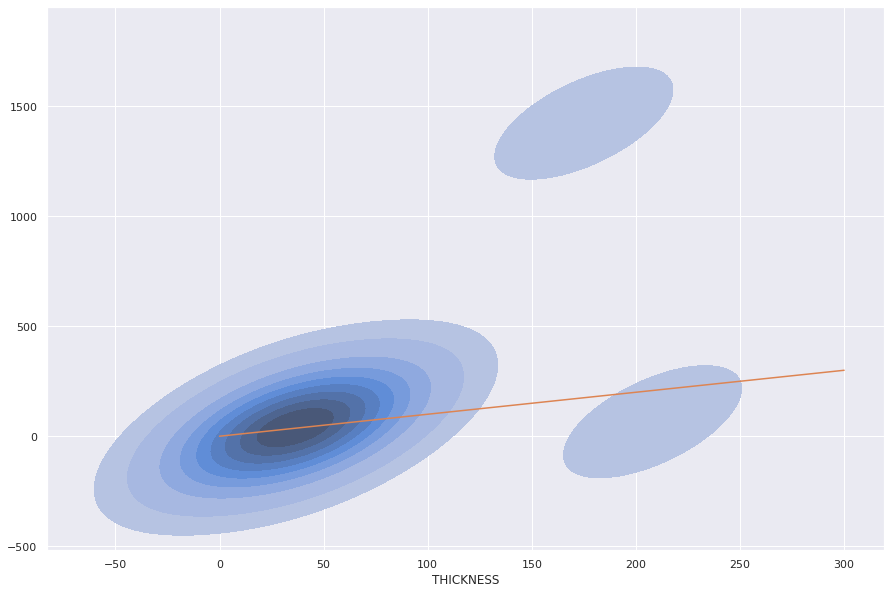

In [12]:
sns.set(rc={"figure.figsize":(15,10)})
sns.kdeplot(x = test_labels, y = y.flatten(),fill = True)
plt.plot((0,300),(0,300),'-')

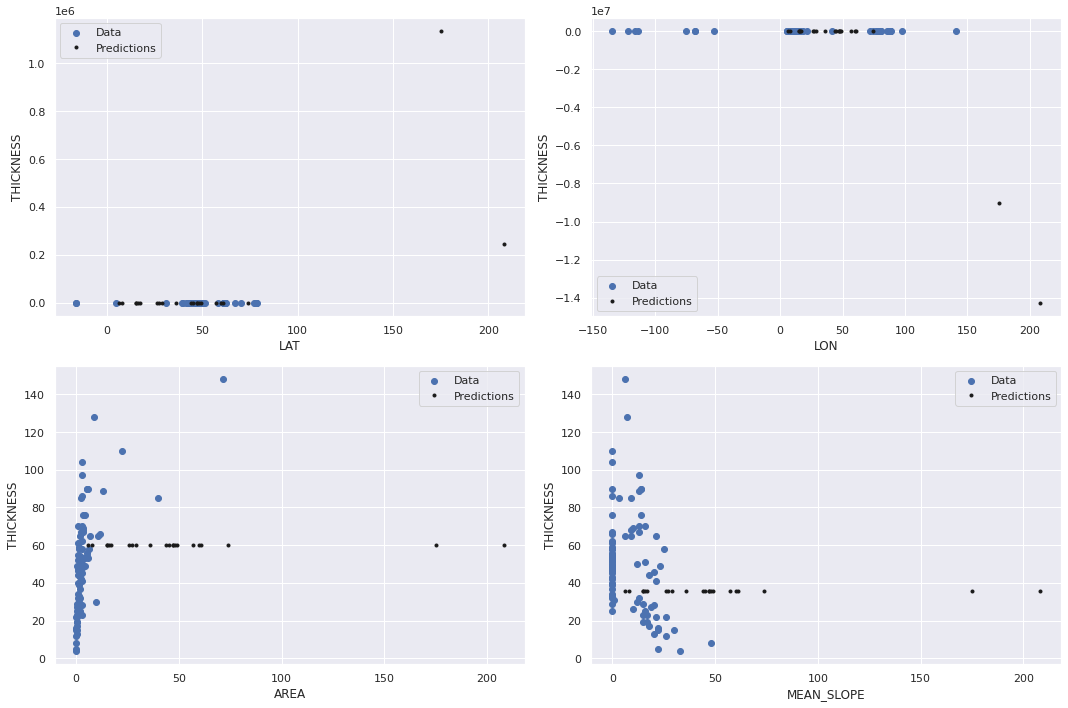

In [13]:
def plot_single_variable(x,y,model_type,model_name,feature_name):
    y = model_type[model_name].predict(test_labels)
    plt.scatter(train_features[feature_name], train_labels, label='Data')
    plt.plot(x, y,'.', color='k', label='Predictions')
    plt.xlabel(feature_name)
    plt.ylabel('THICKNESS')
    plt.legend()
    plt.plot()

x = test_labels
for i, variable_name in enumerate(list(train_features)):
    ax = plt.subplot(2,2,i+1)
    model_name = (dataset.name 
    + '_' 
    + variable_name 
    + '_' 
    + str(lr) 
    + '_' 
    + str(vs) 
    + '_' 
    + str(ep))
    plot_single_variable(x,y,dnn_model, model_name,variable_name)
#     ax.set_ylim([35,140])
#     ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")
plt.tight_layout()

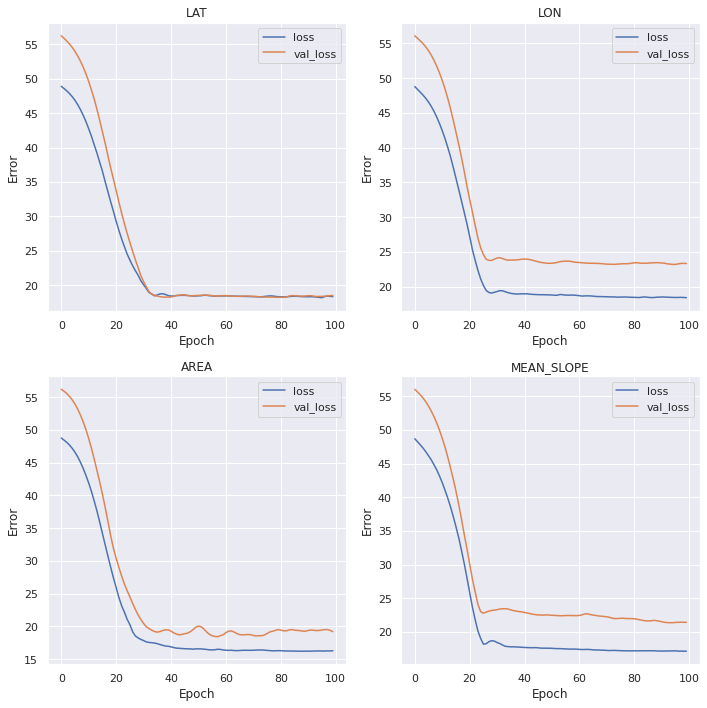

In [14]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
fig.patch.set_facecolor('w')
# gl.plot_loss(dnn_history['T_MULTI'])

for i, variable_name in enumerate(list(train_features)):
    ax = plt.subplot(2,2,i+1)
    gl.plot_loss(dnn_history['glacier_'+ variable_name+ '_0.01_0.2_100'])
#     ax.set_ylim([35,140])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")
plt.tight_layout()

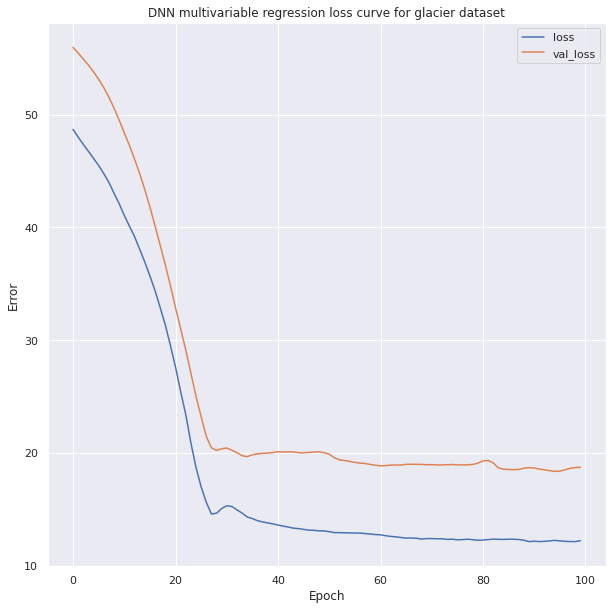

In [15]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
fig.patch.set_facecolor('w')
ax.set_title('DNN multivariable regression loss curve for glacier dataset')
gl.plot_loss(dnn_history['glacier_MULTI_0.01_0.2_100'])
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP_dnn_loss.eps")

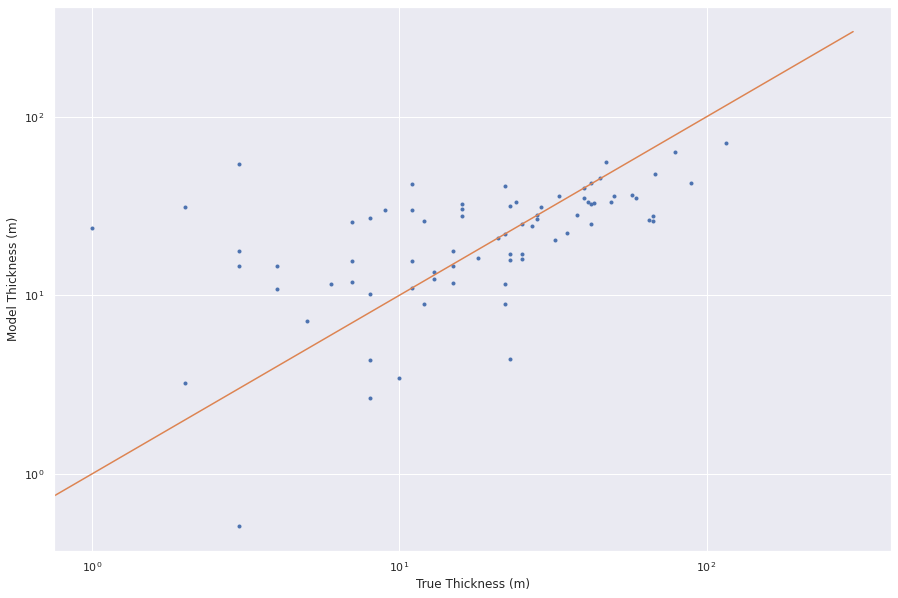

In [16]:
(train_features, test_features,
train_labels, test_labels) = gl.data_splitter(TT)
y = dnn_model['band_MULTI_0.01_0.2_100'].predict(test_features)
fig,ax=plt.subplots(1,1,figsize=(15,10))
fig.patch.set_facecolor('w')
plt.plot(test_labels,y,'.')
plt.plot((0,300),(0,300),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
# plt.xlim((0,300))
# plt.ylim((0,300))
plt.xscale('log')
plt.yscale('log')

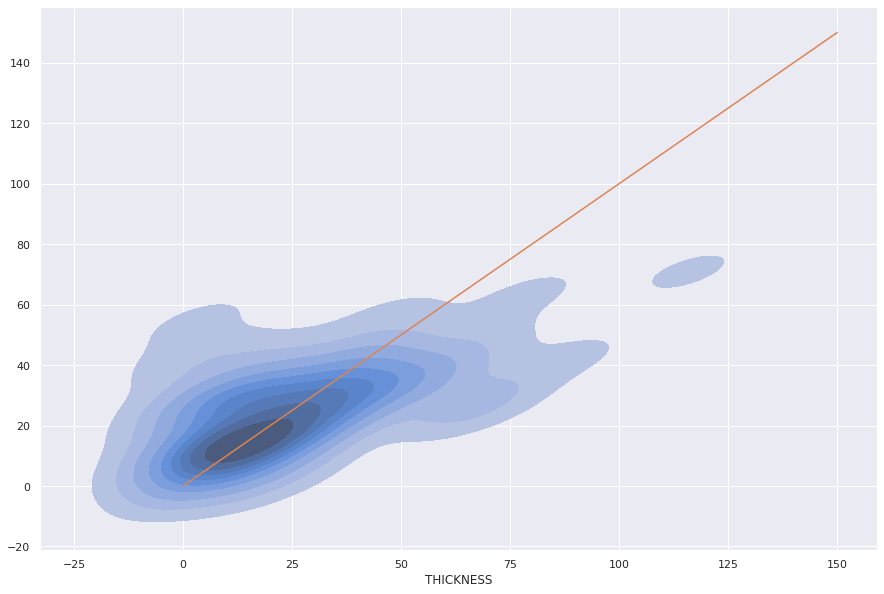

In [17]:
sns.set(rc={"figure.figsize":(15,10)})
sns.kdeplot(x = test_labels, y = y.flatten(),fill = True)
plt.plot((0,150),(0,150),'-')

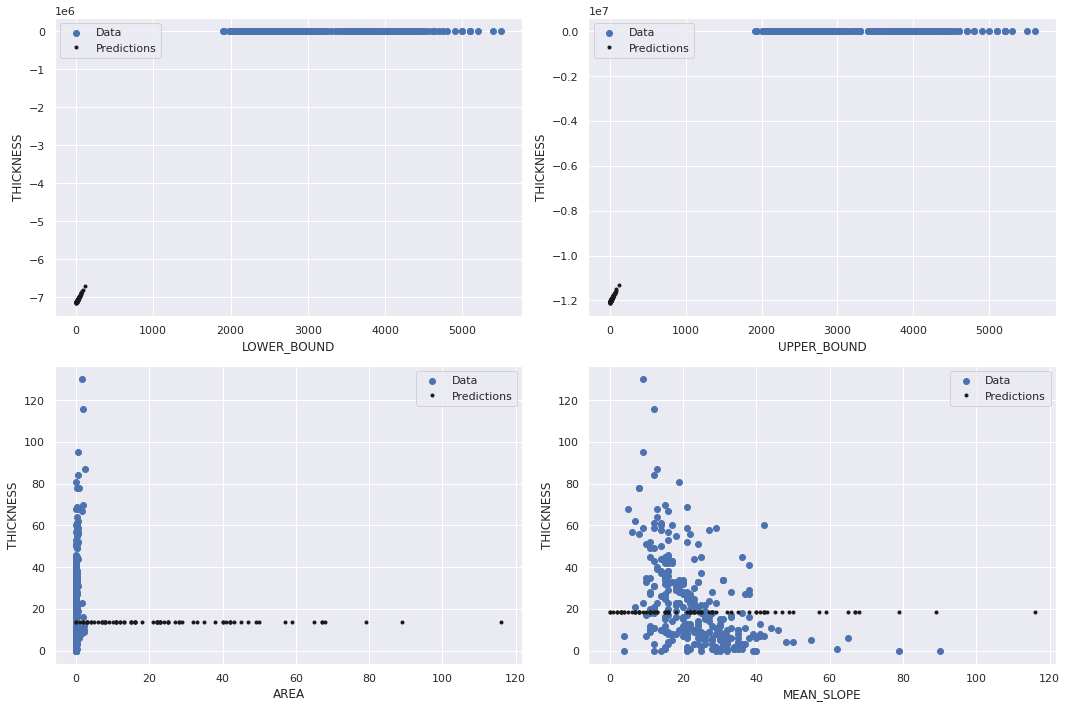

In [18]:
x = test_labels
for i, variable_name in enumerate(list(train_features)):
    ax = plt.subplot(2,2,i+1)
    model_name = ('band' 
    + '_' 
    + variable_name 
    + '_' 
    + str(lr) 
    + '_' 
    + str(vs) 
    + '_' 
    + str(ep))
    plot_single_variable(x,y,dnn_model,model_name,variable_name)
#     ax.set_ylim([35,140])
#     ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")
plt.tight_layout()

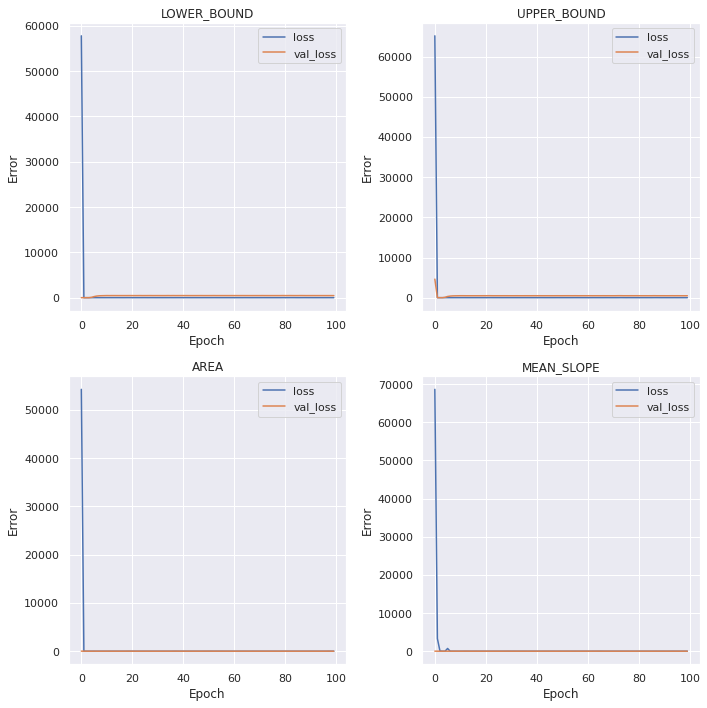

In [27]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
fig.patch.set_facecolor('w')
# gl.plot_loss(dnn_history['TT_MULTI'])

for i, variable_name in enumerate(list(train_features)):
    ax = plt.subplot(2,2,i+1)
    model_name = ('band' 
    + '_' 
    + variable_name 
    + '_' 
    + str(lr) 
    + '_' 
    + str(vs) 
    + '_' 
    + str(ep))
    gl.plot_loss(dnn_history[model_name])
#     ax.set_ylim([10,40])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")
plt.tight_layout()


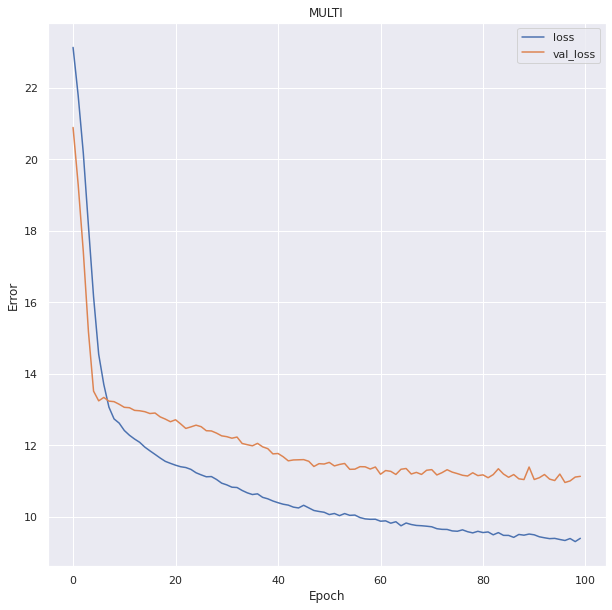

In [28]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
fig.patch.set_facecolor('w')
ax.set_title('MULTI')
gl.plot_loss(dnn_history['band_MULTI_0.01_0.2_100'])

In [ ]:
(train_features, test_features,
train_labels, test_labels) = gl.data_splitter(TTT)
y = dnn_model['TTT_MULTI'].predict(test_features)
fig,ax=plt.subplots(1,1,figsize=(15,10))
fig.patch.set_facecolor('w')
plt.plot(test_labels,y,'.')
plt.plot((0,1300),(0,1300),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((0,1300))
plt.ylim((0,1300))

In [ ]:
sns.set(rc={"figure.figsize":(15,10)})
sns.kdeplot(x = test_labels, y = y.flatten(),fill = True)
plt.plot((0,1300),(0,1300),'-')

In [ ]:

fig,ax=plt.subplots(2,2,figsize=(10,10))
fig.patch.set_facecolor('w')
# gl.plot_loss(dnn_history['TT_MULTI'])

for i, variable_name in enumerate(list(train_features)):
    ax = plt.subplot(2,2,i+1)
    gl.plot_loss(dnn_history['TTT_'+ variable_name])
    ax.set_ylim([152,165])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")
plt.tight_layout()

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
fig.patch.set_facecolor('w')
ax.set_title('MULTI')
gl.plot_loss(dnn_history['TTT_MULTI'])

In [ ]:
(train_features, test_features,
train_labels, test_labels) = gl.data_splitter(TTTx)
y = dnn_model['TTTx_MULTI'].predict(test_features)
plt.plot(test_labels,y,'.')
plt.plot((0,300),(0,300),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((0,300))
plt.ylim((0,300))

In [ ]:
sns.set(rc={"figure.figsize":(15,10)})
sns.kdeplot(x = test_labels, y = y.flatten(),fill = True)
plt.plot((0,300),(0,300),'-')

In [ ]:
fig,ax=plt.subplots(3,3,figsize=(10,10))
fig.patch.set_facecolor('w')
# gl.plot_loss(dnn_history['TT_MULTI'])

for i, variable_name in enumerate(list(train_features)):
    ax = plt.subplot(3,3,i+1)
    gl.plot_loss(dnn_history['TTTx_'+ variable_name])
    ax.set_ylim([30,40])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")
plt.tight_layout()

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
fig.patch.set_facecolor('w')
ax.set_title('TTTx_MULTI')
gl.plot_loss(dnn_history['TTTx_MULTI'])

In [ ]:
(train_features, test_features,
train_labels, test_labels) = gl.data_splitter(TTT_full)
y = dnn_model['TTT_full_MULTI'].predict(test_features)
plt.plot(test_labels,y,'.')
plt.plot((0,300),(0,300),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((0,300))
plt.ylim((0,300))

In [ ]:
sns.set(rc={"figure.figsize":(15,10)})
sns.kdeplot(x = test_labels, y = y.flatten(),fill = True)
plt.plot((0,300),(0,300),'-')

In [ ]:
fig,ax=plt.subplots(3,3,figsize=(10,10))
fig.patch.set_facecolor('w')
# gl.plot_loss(dnn_history['TT_MULTI'])

for i, variable_name in enumerate(list(train_features)):
    ax = plt.subplot(6,6,i+1)
    gl.plot_loss(dnn_history['TTT_full_'+ variable_name])
#     ax.set_ylim([30,40])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")
plt.tight_layout()

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
fig.patch.set_facecolor('w')
ax.set_title('TTT_full_MULTI')
gl.plot_loss(dnn_history['TTT_full_MULTI'])